In [1]:
import sys
sys.path.append("/home/alex/Documents/Doktorarbeit/PiezoHysteresis/python")

import hdf5_tools as h5
from alex_lib import f2t,t2f,matplot, vec2matMH
import numpy as np

import matplotlib.pyplot as plt

from os import listdir

In [ ]:
################################################################################################################
### NOTE: To run this notebook succesfully one have to define elecElemPermittivity in the xml-file as output ###
### And rerun the simulation                                                                                 ###
### Took it out, because it was not stable for testing, to many zero entries                                 ###
################################################################################################################

Testcase:
```
Sketch of Problem:
```Sketch of Problem
######## -> S_N: chargeDensity = 0.0001 for every Harmonic (0-5)
|      |
|      |
######## -> S_S: Ground
```

This is a easy setup, since the electric field lines only doing straight from top to bottom and we are using linear material law:
* Permittivity should be the same for all elements
* Electric flux density is constant over space
* Electric flux density is known: $D=-RHS$ ->ep*elecField this is our referenzsolution 
* Each harmonic is decoupled

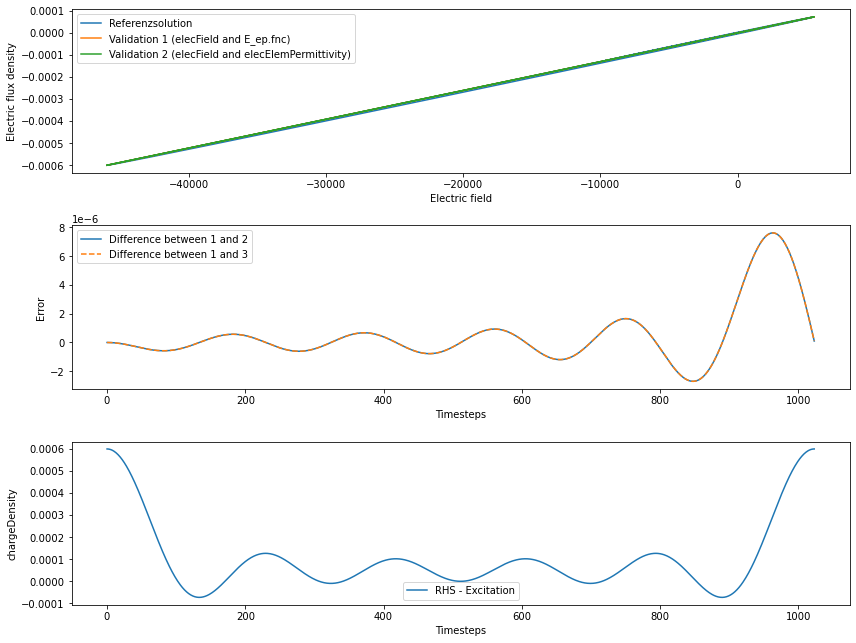

In [2]:
file=listdir("results_hdf5/")[0]
#Nodenumber which is compared
Node=3
#Number of timesteps
Nt=2**10
t=np.linspace(0,2*np.pi,Nt)
#chargeDensity we apply via RHS:
RHS=np.sum(np.array([0.0001 * np.cos(i*t) for i in range(6)]),0)

#Obtaining elecPotential for Node
elecPot=f2t(h5.get_result("results_hdf5/"+file,"elecPotential",step="all")[:,Node],Nt)
#Obtaining elecField in y-direction
elecField_f=h5.get_result("results_hdf5/"+file,"elecFieldIntensity",step="all")[:,1]
elecField=f2t(elecField_f,Nt)
#Obtaining Permittivity
epsilon=h5.get_result("results_hdf5/"+file,"elecElemPermittivity",step="all")
epsilon_m=vec2matMH(epsilon)
#Obtain Material law:
E_ep=np.genfromtxt("E_ep.fnc", delimiter=" ")
# mirror it around the 0Point and interpolate the values for the obtained elecField
ep = np.interp(elecField,np.append(-np.flip(E_ep[:,0]),E_ep[:,0]),np.append(np.flip(E_ep[:,1]),E_ep[:,1]))

fig, ax =plt.subplots(3,figsize=(3*4,3*3))
ax[0].plot(elecField,-RHS, label="Referenzsolution")
ax[0].plot(elecField,ep*elecField, label="Validation 1 (elecField and E_ep.fnc)")
ax[0].plot(elecField,f2t(epsilon_m@elecField_f,Nt), label="Validation 2 (elecField and elecElemPermittivity)")
ax[0].set_xlabel("Electric field")
ax[0].set_ylabel("Electric flux density")
ax[0].legend()

ax[1].plot(RHS+ep*elecField,label="Difference between 1 and 2")
ax[1].plot(RHS+f2t(epsilon_m@elecField_f,Nt), label="Difference between 1 and 3",ls="--")
ax[1].set_xlabel("Timesteps")
ax[1].set_ylabel("Error")
ax[1].legend()

ax[2].plot(RHS, label="RHS - Excitation")
ax[2].set_ylabel("chargeDensity")
ax[2].set_xlabel("Timesteps")
ax[2].legend()

plt.tight_layout()

Insert explaination

In this simple case, the RHS must be the electric Flux density. Somehow there its: RHS = -D . I have to look into this

We excite in every harmonic with the same amplitude. Since its linear, each harmonic is decoupled from the others.
Lets look into each harmonic:

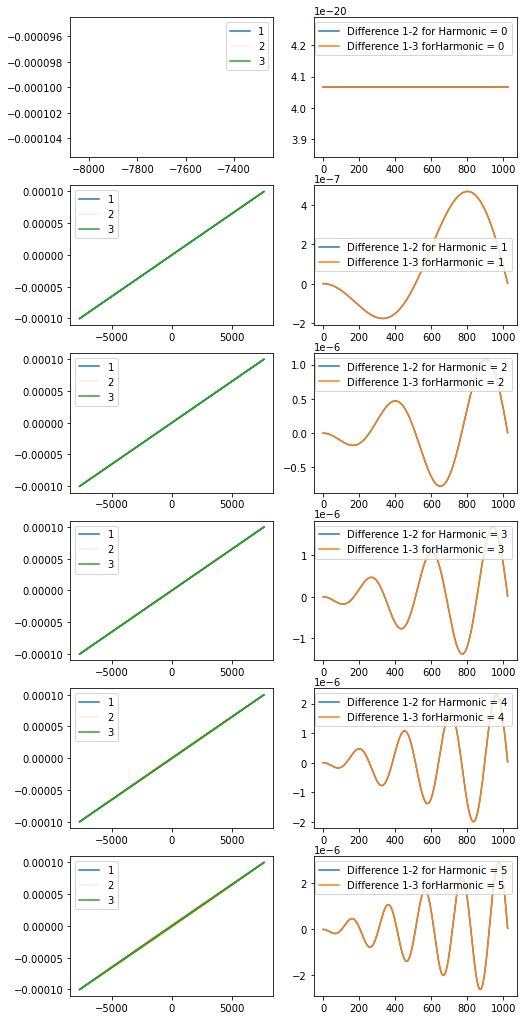

In [3]:
fig, ax = plt.subplots(6,2,figsize=(2*4,6*3))
for h in range(6):
    elecField_f=h5.get_result("results_hdf5/"+file,"elecFieldIntensity",step="all")[:,1]
    x=np.zeros_like(elecField_f)
    x[x.size//2+h]=elecField_f[x.size//2+h]
    x[x.size//2-h]=elecField_f[x.size//2-h]
    elecField=f2t(x,Nt)
    RHS= 0.0001*np.cos(t*h)
    ep = np.interp(elecField,np.append(-np.flip(E_ep[:,0]),E_ep[:,0]),np.append(np.flip(E_ep[:,1]),E_ep[:,1]))
    ax[h,0].plot(elecField,ep*elecField, label="1")
    ax[h,0].plot(elecField,-RHS,label="2", ls="--",lw=0.3)
    ax[h,0].plot(elecField,f2t(epsilon_m@x,Nt),label="3")
    
    
    ax[h,1].plot(RHS+ep*elecField,label=f"Difference 1-2 for Harmonic = {h}")   
    ax[h,1].plot(RHS+f2t(epsilon_m@x,Nt),label=f"Difference 1-3 forHarmonic = {h}")   

    ax[h,0].legend()
    ax[h,1].legend()